Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam
import Augmentor
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r"D:\Upgrad_CodingDocuments\Course4_NeuralNetwroks\Melanoma Detection Assignment\TrainandTest_DataSets\Train")
data_dir_test = pathlib.Path(r"D:\Upgrad_CodingDocuments\Course4_NeuralNetwroks\Melanoma Detection Assignment\TrainandTest_DataSets\Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,        # Use 20% for validation
    subset="training",           # Select the training subset
    seed=123,                    # Set seed for reproducibility
    image_size=(img_height,img_width),  # Resize images
    batch_size=batch_size        # Batch size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,        # Use 20% for validation
    subset="validation",         # Select the validation subset
    seed=123,                    # Set seed for reproducibility
    image_size=(img_height,img_width),  # Resize images
    batch_size=batch_size        # Batch size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
Valclass_names = val_ds.class_names
print(Valclass_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

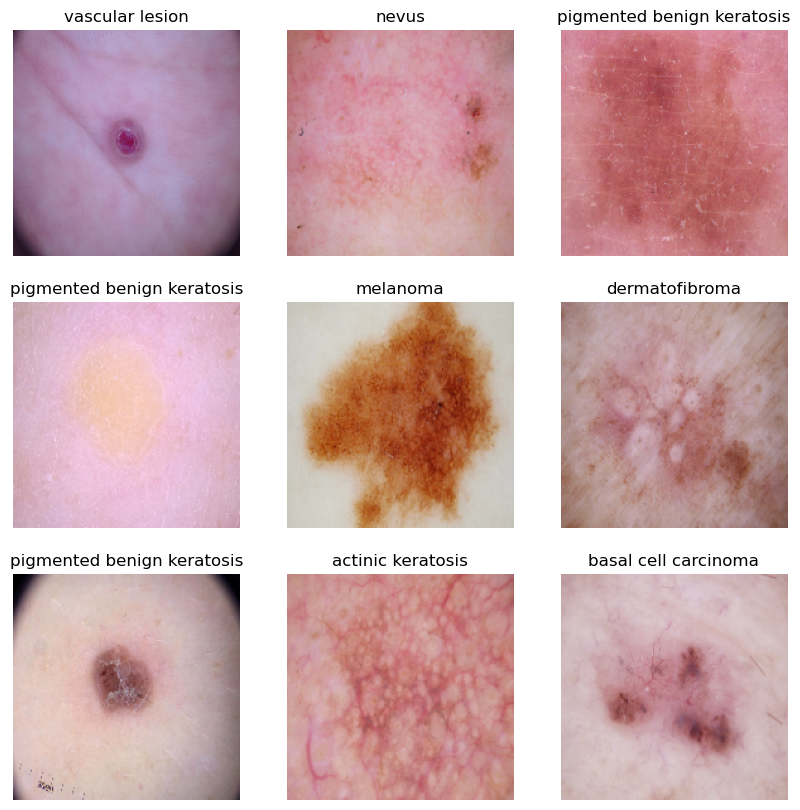

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# Retrieve a batch of images and labels from the training dataset
class_names = train_ds.class_names  # Get the class names from the dataset
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  # Take one batch from the training dataset
    for i in range(9):  # Display first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

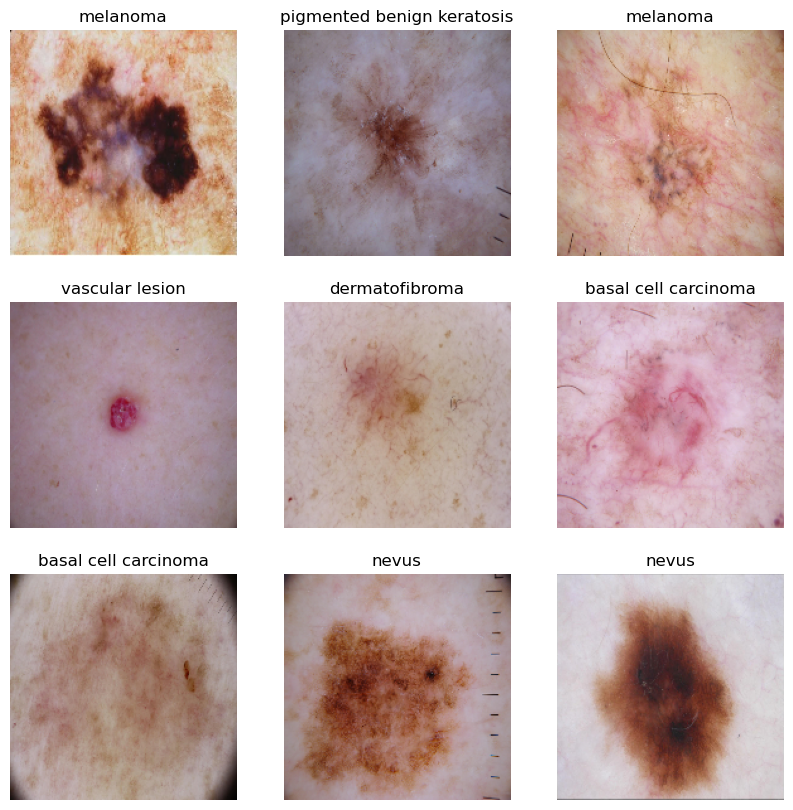

In [10]:
Valclass_names = val_ds.class_names  # Get the class names from the dataset
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):  # Take one batch from the training dataset
    for i in range(9):  # Display first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [11]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

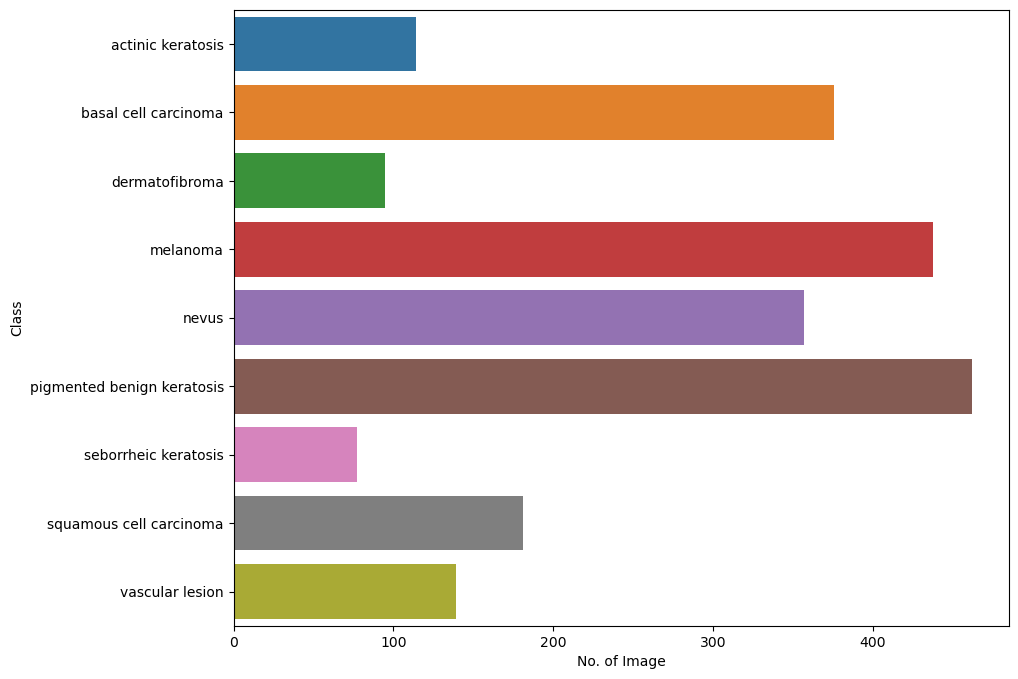

In [12]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,hue='Class',
            label="Class")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
# Define image size and number of classes
img_height, img_width = 180,180  # Adjust based on your dataset
num_classes = 9                   # Number of classes in the dataset

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Build the model
model = models.Sequential([
# Data Augmentation (only applied during training)
layers.InputLayer(input_shape=(img_height, img_width, 3)),
data_augmentation,

# Rescaling layer to normalize pixel values between 0 and 1
layers.Rescaling(1./255),

# First convolutional block
layers.Conv2D(32, (3, 3), activation='relu'),
layers.MaxPooling2D(),

# Second convolutional block
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D(),

# Third convolutional block
layers.Conv2D(128, (3, 3), activation='relu'),
layers.MaxPooling2D(),

# Fourth convolutional block
layers.Conv2D(128, (3, 3), activation='relu'),
layers.MaxPooling2D(),

# Flattening layer to convert 3D feature maps to 1D feature vectors
layers.Flatten(),

# Fully connected (dense) layer
layers.Dense(128, activation='relu'),

# Output layer for classification (Softmax for multi-class)
layers.Dense(num_classes, activation='softmax')
])


C:\Users\SURYA TEJA TALLAM\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam', # Adaptive moment estimation optimizer and for efficient weight updates
              loss='sparse_categorical_crossentropy',  # Suitable for multi-class classification
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,569,225 (5.99 MB)

 Trainable params: 1,569,225 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.2513 - loss: 1.9661 - val_accuracy: 0.4251 - val_loss: 1.6689
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.3909 - loss: 1.7035 - val_accuracy: 0.4295 - val_loss: 1.5896
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - accuracy: 0.3974 - loss: 1.6586 - val_accuracy: 0.4094 - val_loss: 1.6768
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 335ms/step - accuracy: 0.4621 - loss: 1.5196 - val_accuracy: 0.4318 - val_loss: 1.7024
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.4860 - loss: 1.4726 - val_accuracy: 0.4653 - val_loss: 1.6586
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4567 - loss: 1.4859 - val_accuracy: 0.5101 - val_loss: 1.4594
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 548ms/step - accuracy: 0.5085 - loss: 1.4064 - val_accuracy: 0.5302 - val_loss: 1.4455
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 645ms/step - accuracy: 0.4955 - loss: 1.3754 - val_accurac

### Visualizing training results

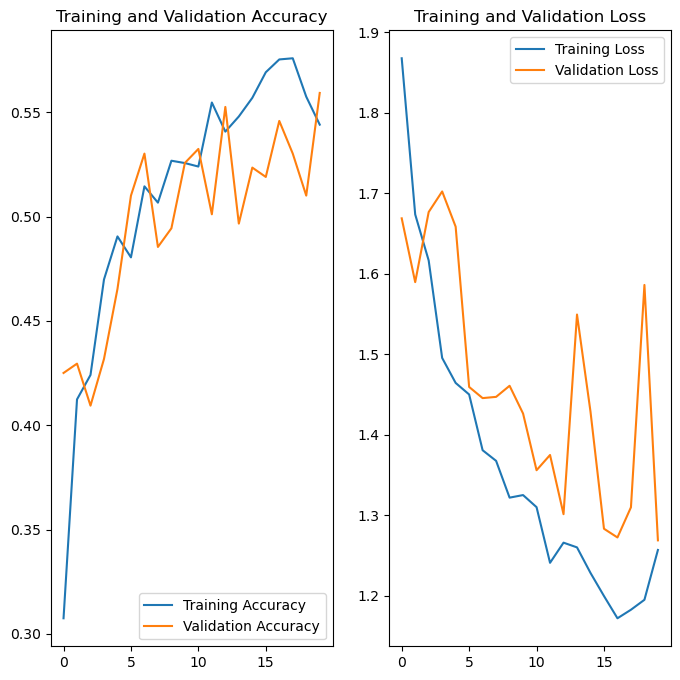

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here


## Based on the training and validation accuracy and loss plots, here are some observations:

### Accuracy:

The training and validation accuracy curves both increase over the epochs, reaching around 59.05% for training and 54.59% for validation at the last epoch. This indicates that the model is learning, but the accuracy levels suggest that there may be room for improvement, possibly due to model capacity, data quality, or other factors.
The gap between training and validation accuracy is relatively small, indicating that overfitting might not be a significant issue.

### Loss:

The training and validation loss both decrease over time, but the validation loss fluctuates more and is consistently higher than the training loss towards the end. This slight increase in the validation loss curve while the training loss continues to decrease can sometimes indicate early signs of overfitting.
The difference between training and validation loss by the end suggests that the model might be fitting slightly better on the training data, which is typical but something to watch for with more training epochs.

### Overfitting/Underfitting:

Given the small difference between training and validation metrics, there's no strong evidence of overfitting. However, the model might not have learned enough to generalize well, which can be a form of UNDERFITTING.
The model’s relatively low accuracy suggests that it could benefit from further tuning, potentially by increasing its complexity, improving data preprocessing, or experimenting with other architectures.

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
# Create ImageDataGenerator for loading and augmenting data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', # Fill pixels after transformations
    validation_split=0.2  # 20% of data will be used for validation
    
)

Agumented_train_ds= train_datagen.flow_from_directory(
    data_dir_train,  
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset="training", 
)

Agumented_val_ds=train_datagen.flow_from_directory(
    data_dir_train,  # Replace with your data directory
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation",
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
AgumentedModel = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    
    # Rescaling layer to normalize pixel values between 0 and 1
    #layers.Rescaling(1./255),
    
    # First convolutional block with stride and padding
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional block with stride and padding
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional block with stride and padding
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Fourth convolutional block with stride and padding
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),Dropout(0.5),

    # Flattening layer to convert 3D feature maps to 1D feature vectors
    layers.Flatten(),

    # Fully connected (dense) layer
    layers.Dense(512, activation='relu'),Dropout(0.5),
    
    # Output layer for classification (Softmax for multi-class)
    layers.Dense(9, activation='softmax')  # Ensure this is 9 units for 9 classes
])

# Print the model summary
AgumentedModel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      10,617,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,010,377 (42.00 MB)

 Trainable params: 11,010,377 (42.00 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [21]:
## Your code goes here
# Compile the model
AgumentedModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
history = AgumentedModel.fit(
    Agumented_train_ds,
    epochs=20, 
    validation_data=Agumented_val_ds,
    callbacks=[checkpoint,earlystop]
)

C:\Users\SURYA TEJA TALLAM\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1956 - loss: 2.1609
Epoch 1: val_accuracy improved from -inf to 0.19595, saving model to model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.1957 - loss: 2.1597 - val_accuracy: 0.1959 - val_loss: 1.9993
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2100 - loss: 2.0061
Epoch 2: val_accuracy improved from 0.19595 to 0.31982, saving model to model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.2108 - loss: 2.0049 - val_accuracy: 0.3198 - val_loss: 1.7558
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3489 - loss: 1.7247
Epoch 3: val_accuracy improved from 0.31982 to 0.32883, saving model to model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3489 - loss: 1.7248 - val_accuracy: 0.3288 - val_loss: 1.7524
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3735 - loss: 1.6827
Epoch 4: val_accuracy did not improve from 0.32883
57/57 ━━━━━━━━━━━━━━

### Visualizing the results

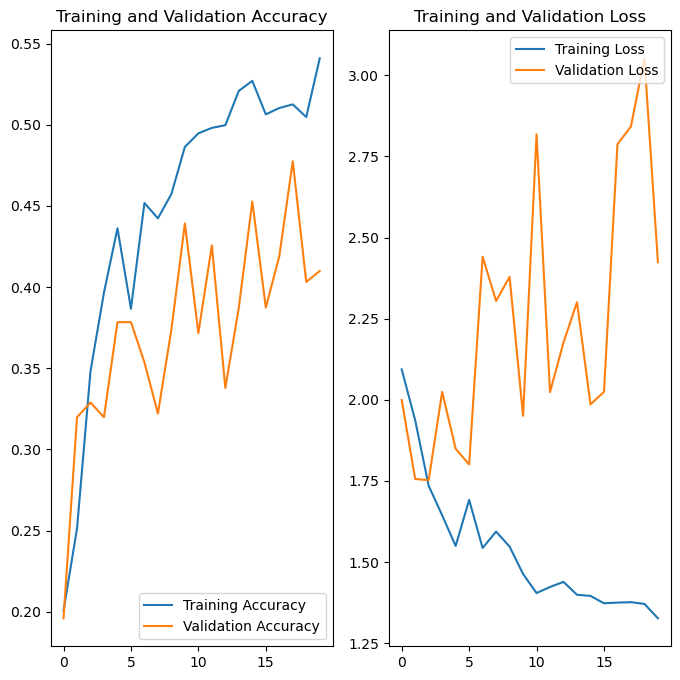

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion 2:: 
##### Even though Agumented the data with ImageDataGenerator still  the Model is UNDERFITTING because having Train Accuracy 51.02% and Validation Accuracy 47.74%
#### At its current state, the model is not performing well. Focus on improving the data, model architecture, or training process to boost performance.

#### Steps to Improve:
1. Examine Data:
Class Imbalance: Ensure that the dataset is balanced or use techniques like oversampling/undersampling or class-weight adjustments.
2. Adjust Model Complexity:
Increase Complexity: If the model is underfitting, try a more complex model (e.g., deeper neural networks, ensemble methods like Random Forests, or XGBoost).
3. Improve Training Process:
Longer Training: Train the model for more epochs, but monitor for overfitting.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class with the least number of samples: seborrheic keratosis (58 samples)
Class with the most number of samples: pigmented benign keratosis (370 samples)


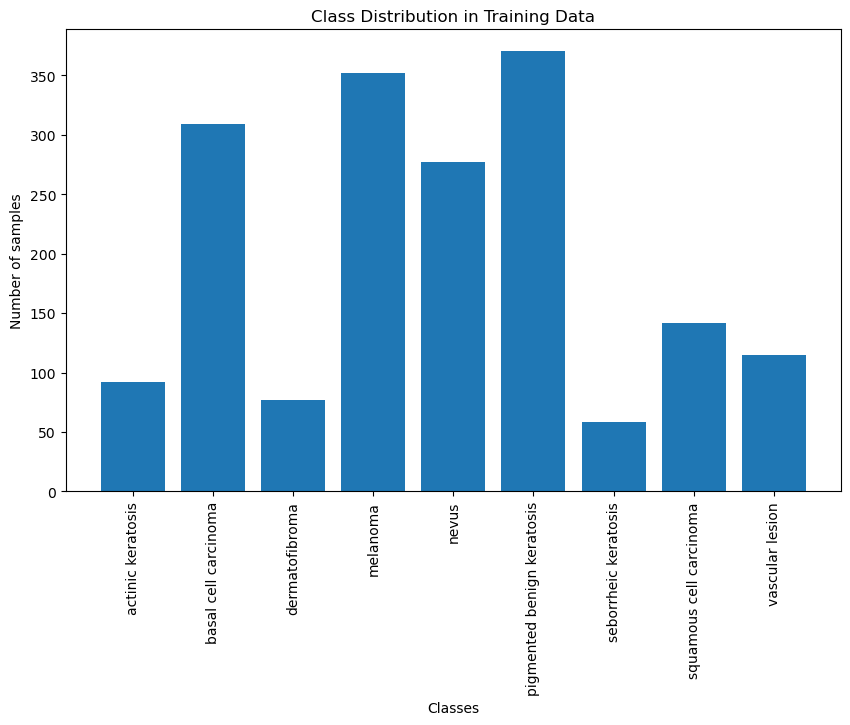

In [24]:
## Your code goes here.
# Get the class labels and the count of samples for each class

#class_names = data_dir_train.class_names  # This gives the class labels from the dataset
class_counts = [0] * len(class_names)

# Count the number of samples per class
for image_batch, label_batch in train_ds:
    for label in label_batch.numpy():
        class_counts[label] += 1

# Convert class_counts to numpy array for easy processing
class_counts = np.array(class_counts)

# Find the class with the least number of samples
least_samples_class_index = np.argmin(class_counts)
least_samples_class = class_names[least_samples_class_index]
least_samples_count = class_counts[least_samples_class_index]

# Find the classes that dominate (i.e., have the most number of samples)
most_samples_class_index = np.argmax(class_counts)
most_samples_class = class_names[most_samples_class_index]
most_samples_count = class_counts[most_samples_class_index]

# Print out the results
print(f"Class with the least number of samples: {least_samples_class} ({least_samples_count} samples)")
print(f"Class with the most number of samples: {most_samples_class} ({most_samples_count} samples)")

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=90)
plt.show()

#### - Which class has the least number of samples?-->Class with the least number of samples: seborrheic keratosis (58 samples)

#### - Which classes dominate the data in terms proportionate number of samples?-->Class with the most number of samples: pigmented benign keratosis (370 samples)


In [25]:
# Define directories
train_dir = "D:/Upgrad_CodingDocuments/Course4_NeuralNetwroks/Melanoma Detection Assignment/TrainandTest_DataSets/Train/"  # Path to your training data
#augmented_dir = "path_to_augmented_train_directory"  # Path where augmented images will be stored

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
class_names = os.listdir(train_dir)  # List all class folders

# Loop through each class and apply augmentation
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    
    # Initialize Augmentor pipeline for the specific class directory
    pipeline = Augmentor.Pipeline(class_path)
    
    # Add transformations for augmentation
    pipeline.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)  # Rotation
    pipeline.flip_left_right(probability=0.7)  # Horizontal flip
    pipeline.flip_top_bottom(probability=0.7)  # Vertical flip
    pipeline.zoom_random(probability=0.7, percentage_area=0.8)  # Random zoom
    pipeline.random_contrast(probability=0.7, min_factor=0.7, max_factor=1.3)  # Contrast adjustment
    pipeline.random_color(probability=0.7, min_factor=0.5, max_factor=1.5)  # Color adjustment

    # Determine the number of samples to generate based on class imbalance
    current_class_sample_count = len(os.listdir(class_path))  # Count current images in the class
    target_samples = 370  # Set target number of images per class (adjust based on the largest class)
    samples_to_generate = max(0, target_samples - current_class_sample_count)  # Images needed to balance
    
    # Apply augmentation if samples are needed
    if samples_to_generate > 0:
        print(f"Generating {samples_to_generate} images for class '{class_name}'...")
        pipeline.sample(samples_to_generate)  # Generate the required number of images


Initialised with 114 image(s) found.
Output directory set to D:/Upgrad_CodingDocuments/Course4_NeuralNetwroks/Melanoma Detection Assignment/TrainandTest_DataSets/Train/actinic keratosis\output.Generating 255 images for class 'actinic keratosis'...


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BA6C38FF50>: 100%|█| 255/255 [00:01<00:00, 144.24 Samples


Initialised with 376 image(s) found.
Output directory set to D:/Upgrad_CodingDocuments/Course4_NeuralNetwroks/Melanoma Detection Assignment/TrainandTest_DataSets/Train/basal cell carcinoma\output.Initialised with 95 image(s) found.
Output directory set to D:/Upgrad_CodingDocuments/Course4_NeuralNetwroks/Melanoma Detection Assignment/TrainandTest_DataSets/Train/dermatofibroma\output.Generating 274 images for class 'dermatofibroma'...


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BA00065B90>: 100%|█| 274/274 [00:01<00:00, 148.82 Samples


Initialised with 438 image(s) found.
Output directory set to D:/Upgrad_CodingDocuments/Course4_NeuralNetwroks/Melanoma Detection Assignment/TrainandTest_DataSets/Train/melanoma\output.Initialised with 357 image(s) found.
Output directory set to D:/Upgrad_CodingDocuments/Course4_NeuralNetwroks/Melanoma Detection Assignment/TrainandTest_DataSets/Train/nevus\output.Generating 12 images for class 'nevus'...


Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x1BA6A9B6A50>: 100%|█| 12/12 [00:01<00:00, 10.65 Samples/


Initialised with 462 image(s) found.
Output directory set to D:/Upgrad_CodingDocuments/Course4_NeuralNetwroks/Melanoma Detection Assignment/TrainandTest_DataSets/Train/pigmented benign keratosis\output.Initialised with 77 image(s) found.
Output directory set to D:/Upgrad_CodingDocuments/Course4_NeuralNetwroks/Melanoma Detection Assignment/TrainandTest_DataSets/Train/seborrheic keratosis\output.Generating 292 images for class 'seborrheic keratosis'...


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1BA0019B390>: 100%|█| 292/292 [00:04<00:00, 66.25 Samples


Initialised with 181 image(s) found.
Output directory set to D:/Upgrad_CodingDocuments/Course4_NeuralNetwroks/Melanoma Detection Assignment/TrainandTest_DataSets/Train/squamous cell carcinoma\output.Generating 188 images for class 'squamous cell carcinoma'...


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BA00227810>: 100%|█| 188/188 [00:01<00:00, 155.23 Samples


Initialised with 139 image(s) found.
Output directory set to D:/Upgrad_CodingDocuments/Course4_NeuralNetwroks/Melanoma Detection Assignment/TrainandTest_DataSets/Train/vascular lesion\output.Generating 230 images for class 'vascular lesion'...


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BA6A7FE350>: 100%|█| 230/230 [00:01<00:00, 159.09 Samples


In [27]:
#path_to_training_dataset="To do"
#import Augmentor
#for i in class_names:
    #p = Augmentor.Pipeline(path_to_training_dataset + i)
    #p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    #p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

1251


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['D:\\Upgrad_CodingDocuments\\Course4_NeuralNetwroks\\Melanoma Detection Assignment\\TrainandTest_DataSets\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3abcbeeb-c87c-49d6-9cab-2c0a6b0b200d.jpg',
 'D:\\Upgrad_CodingDocuments\\Course4_NeuralNetwroks\\Melanoma Detection Assignment\\TrainandTest_DataSets\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3aca43f5-ae08-4cf9-90eb-ce4c82e770bd.jpg',
 'D:\\Upgrad_CodingDocuments\\Course4_NeuralNetwroks\\Melanoma Detection Assignment\\TrainandTest_DataSets\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_50ab2b95-1bdb-4f04-b7c3-9fc2b3b8cb00.jpg',
 'D:\\Upgrad_CodingDocuments\\Course4_NeuralNetwroks\\Melanoma Detection Assignment\\TrainandTest_DataSets\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_afdd8c09-29cb-4bdb-8604-8eba7c485a52.jpg',
 'D:\\Upgrad_CodingDocuments\\Course4_NeuralNetwroks\\Melanoma Detection Assignment\

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df=pd.DataFrame(columns=['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [33]:
new_df['Label'].value_counts()

Label
seborrheic keratosis       292
dermatofibroma             274
actinic keratosis          255
vascular lesion            230
squamous cell carcinoma    188
nevus                       12
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,        # Use 20% for validation
    subset="training",           # Select the training subset
    seed=123,                    # Set seed for reproducibility
    image_size=(img_height,img_width),  # Resize images
    batch_size=batch_size,        # Batch size
    label_mode='categorical'
)

Found 3490 files belonging to 9 classes.
Using 2792 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,        # Use 20% for validation
    subset="training",           # Select the training subset
    seed=123,                    # Set seed for reproducibility
    image_size=(img_height,img_width),  # Resize images
    batch_size=batch_size,        # Batch size
    label_mode='categorical'
)

Found 3490 files belonging to 9 classes.
Using 2792 files for training.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
## your code goes here
AgumentedModel2 = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    
    # Rescaling layer to normalize pixel values between 0 and 1
    layers.Rescaling(1./255),
    
    # Add a GlobalAveragePooling layer instead of Flatten (helps reduce overfitting)
    #layers.GlobalAveragePooling2D(),
    
     # First convolutional block with stride and padding
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Second convolutional block with stride and padding
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Third convolutional block with stride and padding
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Fourth convolutional block with stride and padding
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),Dropout(0.5),
    
    
    # Flattening layer to convert 3D feature maps to 1D feature vectors
    layers.Flatten(),
    
    # Fully connected (dense) layer
    layers.Dense(512, activation='relu'),
    
    #Batch Normalisation
    layers.BatchNormalization(),
    
    # Output layer for classification (Softmax for multi-class)
    layers.Dense(9, activation='softmax')  # Ensure this is 9 units for 9 classes
])

# Print the model summary
AgumentedModel2.summary()


C:\Users\SURYA TEJA TALLAM\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      10,617,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,012,425 (42.01 MB)

 Trainable params: 11,011,401 (42.01 MB)

 Non-trainable params: 1,024 (4.00 KB)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here
## Your code goes here
# Compile the model
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

#AgumentedModel2.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
AgumentedModel2.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=10,mode="auto",verbose=1)

#### **Todo:**  Train your model

In [39]:
epochs = 30
## Your code goes here, use 50 epochs.
history =  AgumentedModel2.fit(
    train_ds,
    epochs=epochs, 
    validation_data=val_ds,
    callbacks=[checkpoint,earlystop]
)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.2174 - loss: 2.1042
Epoch 1: val_accuracy improved from -inf to 0.35136, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 340ms/step - accuracy: 0.2184 - loss: 2.1016 - val_accuracy: 0.3514 - val_loss: 2.1049
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.4247 - loss: 1.5424
Epoch 2: val_accuracy improved from 0.35136 to 0.45702, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 409ms/step - accuracy: 0.4248 - loss: 1.5421 - val_accuracy: 0.4570 - val_loss: 2.0055
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.4713 - loss: 1.3915
Epoch 3: val_accuracy improved from 0.45702 to 0.50394, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 363ms/step - accuracy: 0.4713 - loss: 1.3916 - val_accuracy: 0.5039 - val_loss: 1.9077
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.5128 - loss: 1.3358
Epoch 4: val_accuracy did not improve from 0.50394
88

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8997 - loss: 0.3003
Epoch 25: val_accuracy improved from 0.93016 to 0.93732, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 466ms/step - accuracy: 0.8997 - loss: 0.3002 - val_accuracy: 0.9373 - val_loss: 0.1975
Epoch 26/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9069 - loss: 0.2718
Epoch 26: val_accuracy did not improve from 0.93732
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - accuracy: 0.9070 - loss: 0.2718 - val_accuracy: 0.9277 - val_loss: 0.2190
Epoch 27/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9150 - loss: 0.2602
Epoch 27: val_accuracy improved from 0.93732 to 0.95236, saving model to model.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 489ms/step - accuracy: 0.9150 - loss: 0.2601 - val_accuracy: 0.9524 - val_loss: 0.1548
Epoch 28/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9126 - loss: 0.2577
Epoch 28: val_accuracy improved from 0.95236 to 0.95451, saving model to model.keras
88/

#### **Todo:**  Visualize the model results

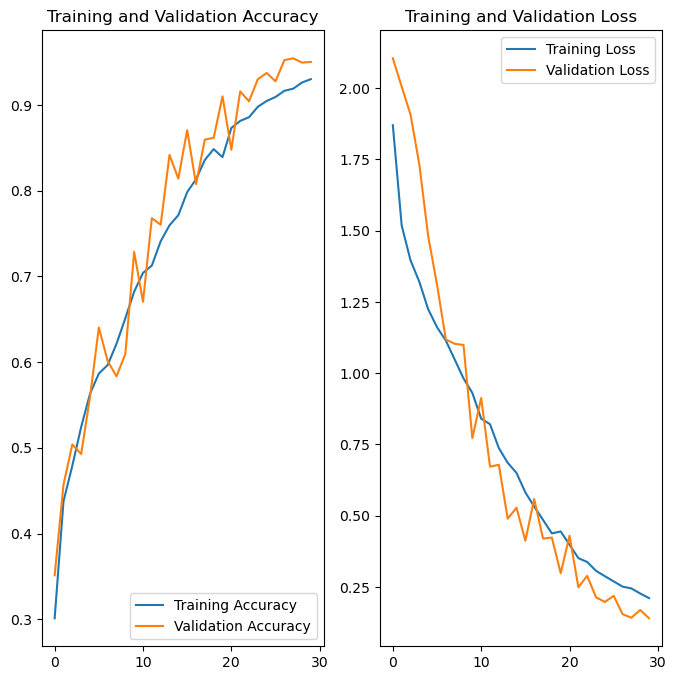

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting?-->yes  Did class rebalance help?-->yes

### After Handling the Class imbalance by adding the Agumented data, Model was get rid of UNDERFITTING

### Train Accuracy: 0.9127 (91.27%):

1. The model performs well on the training data, capturing the majority of patterns.
2. Train Loss: 0.2576:A relatively low loss value indicates that the model predictions align closely with the actual labels in the training set.

### Validation Accuracy: 0.9545 (95.45%):

A higher validation accuracy than training accuracy suggests the model generalizes well to unseen data. This is usually a good sign.

#### Validation Loss: 0.1422:
1. The validation loss is significantly lower than the training loss, which can indicate:
2. The model may generalize better to the validation data.
3. The validation set might be simpler or less noisy compared to the training data.

### Performance Perspective:
1. The accuracy values are high for both training and validation, suggesting that the model is likely effective for its intended purpose.
2. The lower validation loss compared to training loss further supports that the model generalizes well to unseen data.